# Additional Analysis 
- Plotting single trials
- Investigating alternative variables for blink detection
- Plotting individual blinks

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

initial_df = pd.read_csv('D:/PilotData/08_ET_Data_2025-08-28.csv') # Insert path to csv

C:\Users\jonna\AppData\Local\Temp\ipykernel_4712\3695002875.py:5: DtypeWarning: Columns (43) have mixed types. Specify dtype option on import or set low_memory=False.
  initial_df = pd.read_csv('D:/PilotData/08_ET_Data_2025-08-28.csv') # Insert path to csv


Partial evidence that left_eye_openness and right_eye_openness is not a good indicator for blinks:

In [ ]:
left_zero_count = (initial_df['left_eye_openness'] <= 0.3).sum()
right_zero_count = (initial_df['right_eye_openness'] <= 0.3).sum()

def count_consecutive_zero_periods(pupil_data):
    """
    Counts number of consecutive runs of zeros in a 1D array or pandas Series.
    """
    is_zero = (pupil_data == 0).astype(int)
    
    # Find where zero runs start: when current is 1 and previous is 0
    starts = (is_zero.diff().fillna(is_zero.iloc[0]) == 1)
    
    # Number of zero runs is sum of start locations
    count = starts.sum()
    
    return count

left_zero_runs = count_consecutive_zero_periods(initial_df['left_pupil_diameter'])
right_zero_runs = count_consecutive_zero_periods(initial_df['right_pupil_diameter'])

print(f"Left eye openness blink count: {left_zero_count}")
print(f"Right eye openness blink count: {right_zero_count}")

print(f"Left pupil diameter blink count: {left_zero_runs}")
print(f"Right pupil diameter blink count: {left_zero_runs}")

Add columns 'time' is seconds and 'blink' (bool):

In [ ]:
# Convert gaze_capture_time into seconds
initial_df['gaze_capture_time'] = pd.to_datetime(initial_df['gaze_capture_time'])

# If 'gaze_capture_time' is in nanoseconds, convert to seconds for elapsed time
if pd.api.types.is_integer_dtype(initial_df['gaze_capture_time']):
    initial_df['time'] = (initial_df['gaze_capture_time'] - initial_df['gaze_capture_time'].iloc[0]) / 1e9
else:
    # If already datetime, use total seconds from the first timestamp
    initial_df['time'] = (pd.to_datetime(initial_df['gaze_capture_time']) - pd.to_datetime(initial_df['gaze_capture_time'].iloc[0])).dt.total_seconds()
    
# Add a column for blinks
initial_df['blink'] = (initial_df['left_pupil_diameter'] == 0) | (initial_df['right_pupil_diameter'] == 0) 

,time,model_name,is_building_model
0,0.000000,NaN,False
1,0.005000,NaN,False
2,0.010002,NaN,False
3,0.015003,NaN,False
4,0.020004,NaN,False
...,...,...,...
494788,3301.183566,NaN,False
494789,3301.188567,NaN,False
494790,3301.193567,NaN,False
494791,3301.198568,NaN,False


In [33]:
# Select only relevant columns
columns_to_keep = ['time', 'left_pupil_diameter', 'right_pupil_diameter', 'is_building_model', 'model_name', 'left_eye_openness', 'right_eye_openness', 'blink', 'left_status', 'right_status']

relevant_df = initial_df[columns_to_keep]

Plot raw pupil diameter for a single trial:

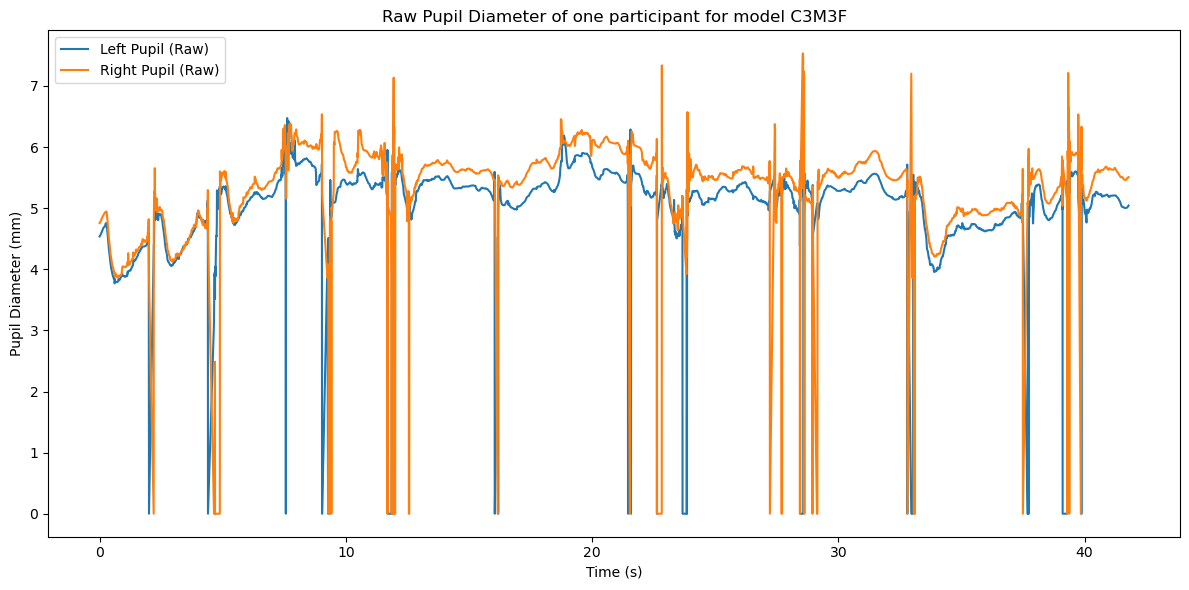

In [ ]:
# Select which trial to plot

# Extract all continuous true periods as a list
is_true = relevant_df['is_building_model']
change_points = is_true.ne(is_true.shift()).cumsum()
true_groups = relevant_df[is_true].groupby(change_points[is_true])
true_periods = [grp for _, grp in true_groups]

# Select the relevant period (0-6)
selected_period_df = true_periods[2].copy()

# Subtract start time to normalize time axis to 0
relative_time = selected_period_df['time'] - selected_period_df['time'].iloc[0]

# Plot
plt.figure(figsize=(12, 6))
plt.plot(relative_time, selected_period_df['left_pupil_diameter'], label='Left Pupil (Raw)')
plt.plot(relative_time, selected_period_df['right_pupil_diameter'], label='Right Pupil (Raw)')
plt.xlabel('Time (s)')
plt.ylabel('Pupil Diameter (mm)')
plt.title('Raw Pupil Diameter of one participant for model [FILL IN]') # Insert which model
plt.legend() 
plt.tight_layout()
plt.show()

Plot eye openness together with the blinks detected by pupil diameter for one building period:

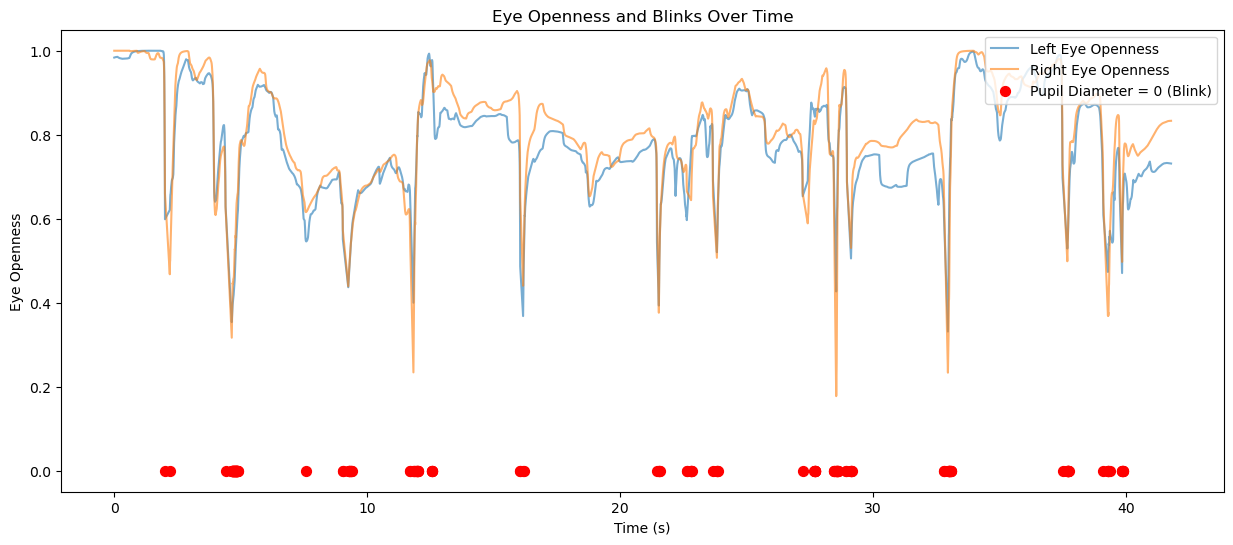

In [67]:
plt.figure(figsize=(15, 6))
plt.plot(relative_time, selected_period_df['left_eye_openness'], label='Left Eye Openness', alpha=0.6)
plt.plot(relative_time, selected_period_df['right_eye_openness'], label='Right Eye Openness', alpha=0.6)
blink_times = relative_time[selected_period_df['blink']]
plt.scatter(blink_times, [0]*len(blink_times), color='red', s=50, label='Pupil Diameter = 0 (Blink)')

plt.xlabel('Time (s)')
plt.ylabel('Eye Openness')
plt.legend(loc='upper right')
plt.title('Eye Openness and Blinks Over Time')
plt.show()

Plot left_status and right_status with blinks to see correlation:

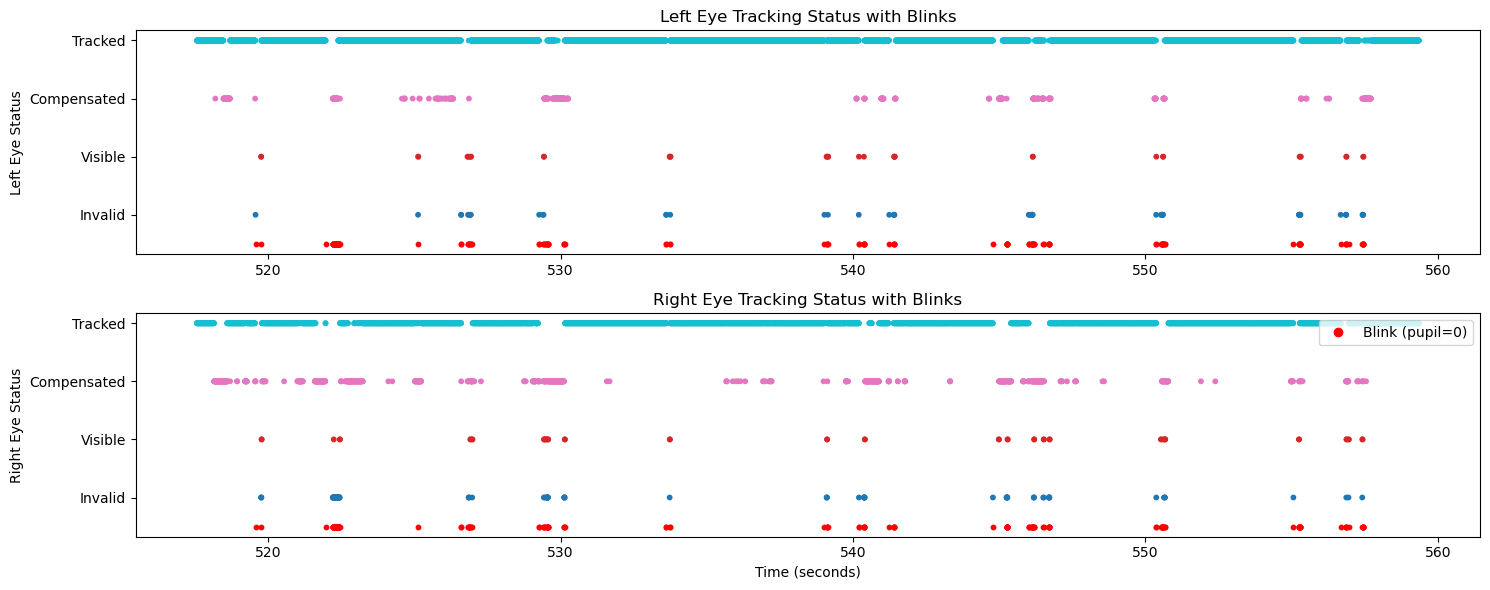

In [53]:
# Map status strings to numbers for visualization
status_mapping = {
    'Tracked': 3,
    'Compensated': 2,
    'Visible': 1,
    'Invalid': 0
}

selected_period_df['left_status_code'] = selected_period_df['left_status'].map(status_mapping)
selected_period_df['right_status_code'] = selected_period_df['right_status'].map(status_mapping)

plt.figure(figsize=(15, 6))

# Plot left eye status codes
plt.subplot(2, 1, 1)
plt.scatter(selected_period_df['time'], selected_period_df['left_status_code'], c=selected_period_df['left_status_code'], cmap='tab10', s=10)
plt.yticks(list(status_mapping.values()), list(status_mapping.keys()))
plt.ylabel('Left Eye Status')
plt.title('Left Eye Tracking Status with Blinks')

# Plot right eye status codes
plt.subplot(2, 1, 2)
plt.scatter(selected_period_df['time'], selected_period_df['right_status_code'], c=selected_period_df['right_status_code'], cmap='tab10', s=10)
plt.yticks(list(status_mapping.values()), list(status_mapping.keys()))
plt.ylabel('Right Eye Status')
plt.xlabel('Time (seconds)')
plt.title('Right Eye Tracking Status with Blinks')

# Add red dots for blink events on both subplots
blink_times = selected_period_df.loc[initial_df['blink'], 'time']

for ax in plt.gcf().axes:
    ax.scatter(blink_times, [-0.5]*len(blink_times), color='red', s=10, label='Blink (pupil=0)')
    # Use y=-0.5 so dots appear slightly below status ticks

# Custom legend handle for red dots
import matplotlib.lines as mlines
blink_handle = mlines.Line2D([], [], color='red', marker='o', linestyle='None', markersize=6, label='Blink (pupil=0)')

plt.gca().legend(handles=[blink_handle], loc='upper right')

plt.tight_layout()
plt.show()

Plot only invalid status points:

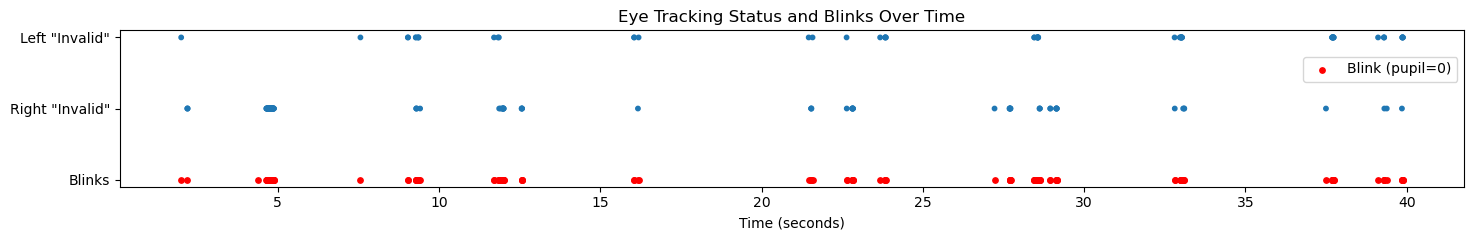

In [87]:
# Calculate zero-based relative time
relative_time = selected_period_df['time'] - selected_period_df['time'].iloc[0]

# Use relative_time for plotting instead of absolute time
plt.figure(figsize=(15, 2.5))

# Shift y-values to stack plots vertically with close spacing
left_y = selected_period_df['left_status_code'] + 2   # Shift to ~2 on y axis
right_y = selected_period_df['right_status_code'] + 1 # Shift to ~1 on y axis

# Blink y-values at 0 (just below eye statuses)
blink_y = np.zeros(shape=selected_period_df['blink'].sum())

# Plot left eye status
plt.scatter(relative_time, left_y, c=selected_period_df['left_status_code'], cmap='tab10', s=10)
# Plot right eye status
plt.scatter(relative_time, right_y, c=selected_period_df['right_status_code'], cmap='tab10', s=10)

# Plot blinks (using the times when blink == True)
blink_times = relative_time[selected_period_df['blink']]
plt.scatter(blink_times, blink_y, color='red', s=15, label='Blink (pupil=0)')

# Set y-ticks to correspond to eye statuses and blinks
plt.yticks([0, 1, 2], ['Blinks', 'Right "Invalid"', 'Left "Invalid"'])

plt.xlabel('Time (seconds)')
plt.title('Eye Tracking Status and Blinks Over Time')

plt.legend(loc='center left', bbox_to_anchor=(0.875, 0.75))

plt.tight_layout()
plt.show()

Plot preprocessed pupil diameter for a single trial with a fixed buffer window around each blink:

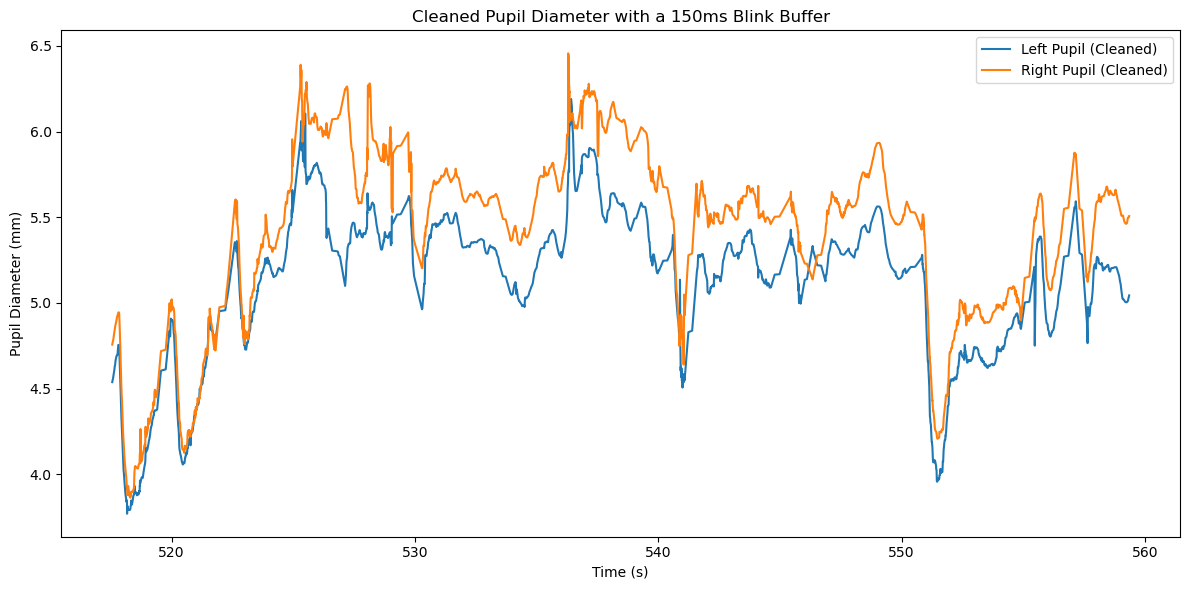

In [38]:
clean_df = selected_period_df.copy()

# Remove blinks
buffer_samples = 30 # adjust as needed (10-30, correspond to 50-150ms)
blink_mask = clean_df['blink']

# Blink buffer function
def add_blink_buffer(blink_mask, buffer):
    # Blink mask where blink = True
    blink_mask = clean_df['blink']
    
    # Get indices of blink points
    blink_idxs = np.where(blink_mask)[0]
    
    # Expanded mask
    expanded_mask = np.zeros(len(blink_mask), dtype=bool)
    
    # For each blink index, mask from (idx - buffer) to (idx + buffer)
    for idx in blink_idxs:
        start = max(0, idx - buffer)
        end = min(len(blink_mask), idx + buffer + 1)
        expanded_mask[start:end] = True
        
    return expanded_mask

# Apply buffering to blink column
buffer_mask = add_blink_buffer(blink_mask.values, buffer_samples)

# Set buffered blink regions to NaN in the DataFrame
clean_df.loc[buffer_mask, 'left_pupil_diameter'] = np.nan
clean_df.loc[buffer_mask, 'right_pupil_diameter'] = np.nan

# Interpolate to fill NaNs, using linear interpolation
clean_df['left_pupil_diameter'] = clean_df['left_pupil_diameter'].interpolate(method='linear', limit_direction='both')
clean_df['right_pupil_diameter'] = clean_df['right_pupil_diameter'].interpolate(method='linear', limit_direction='both')

# Plot both eyes individually
plt.figure(figsize=(12, 6)) 
 
plt.plot(clean_df['time'], clean_df['left_pupil_diameter'], label='Left Pupil (Cleaned)') 
plt.plot(clean_df['time'], clean_df['right_pupil_diameter'], label='Right Pupil (Cleaned)')

plt.xlabel('Time (s)')
plt.ylabel('Pupil Diameter (mm)')
plt.title('Cleaned Pupil Diameter with a 150ms Blink Buffer')
plt.legend()
plt.tight_layout()
plt.show()

Plot mean pupil diameter for a single trial:

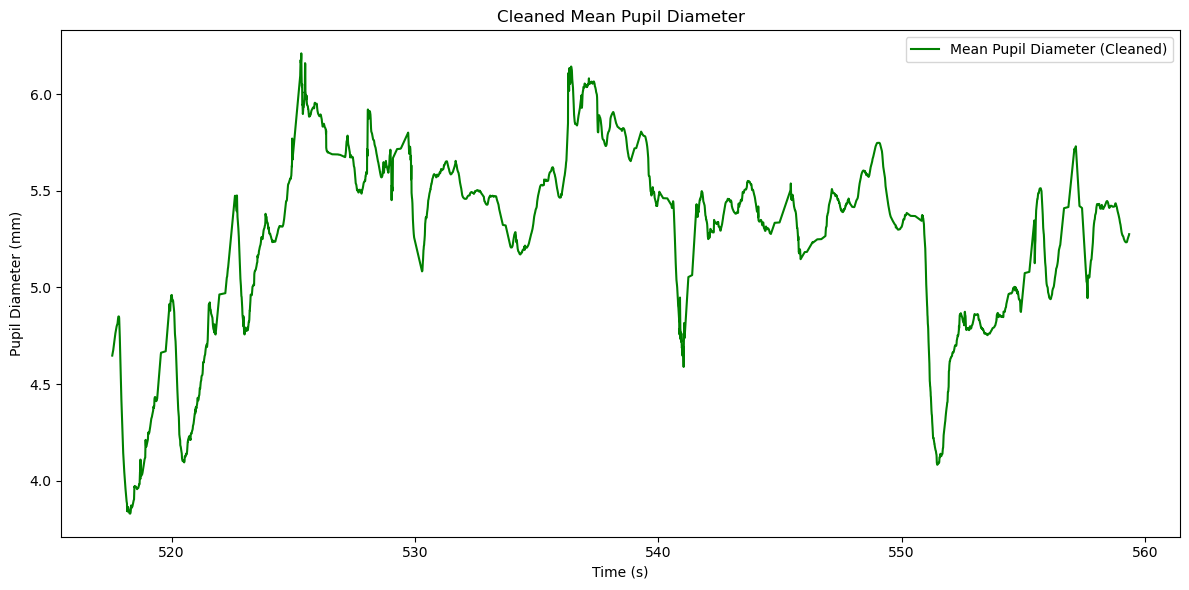

In [39]:
# Get Mean of left and right pupil diameter
clean_df['mean_pupil_diameter'] = clean_df[['left_pupil_diameter', 'right_pupil_diameter']].mean(axis=1)

# Plot mean
plt.figure(figsize=(12, 6))

plt.plot(clean_df['time'], clean_df['mean_pupil_diameter'], color='green', label='Mean Pupil Diameter (Cleaned)')

plt.xlabel('Time (s)')
plt.ylabel('Pupil Diameter (mm)')
plt.title('Cleaned Mean Pupil Diameter')
plt.legend()
plt.tight_layout()
plt.show()

Visualising a single raw blink:

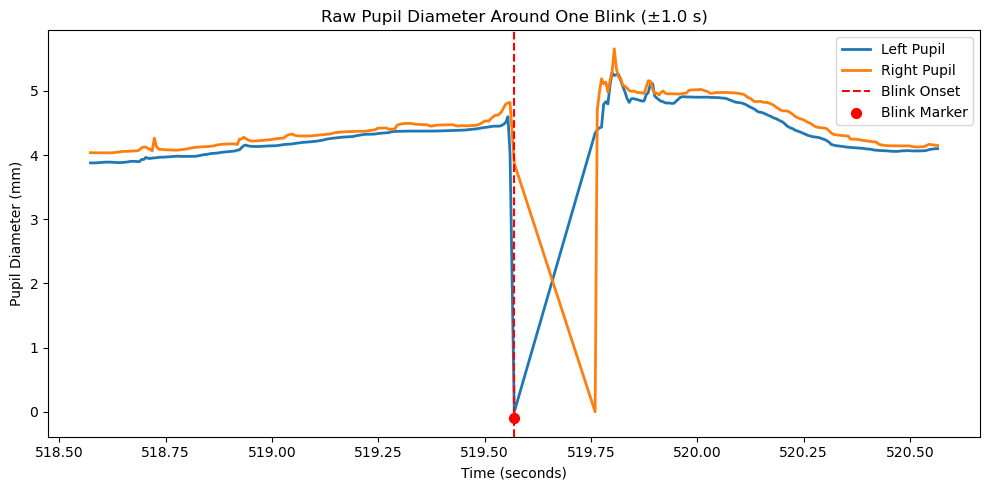

In [ ]:
# Parameters
window_before = 1.0  # seconds before the blink
window_after = 1.0   # seconds after the blink

# Find index of first blink occurrence
first_blink_idx = selected_period_df.index[selected_period_df['blink']].min()

# Get the time of this blink
blink_time = selected_period_df.loc[first_blink_idx, 'time']

# Define time range for the window
start_time = blink_time - window_before
end_time = blink_time + window_after

# Subset data within this window
window_df = selected_period_df[(selected_period_df['time'] >= start_time) & (selected_period_df['time'] <= end_time)]

# Plotting
plt.figure(figsize=(10, 5))

plt.plot(window_df['time'], window_df['left_pupil_diameter'], label='Left Pupil', linewidth=2)
plt.plot(window_df['time'], window_df['right_pupil_diameter'], label='Right Pupil', linewidth=2)

plt.axvline(blink_time, color='red', linestyle='--', label='Blink Onset')

fixed_y = window_df[['left_pupil_diameter', 'right_pupil_diameter']].min().min() - 0.1
plt.scatter([blink_time], [fixed_y], color='red', s=50, label='Blink Marker')

plt.xlabel('Time (seconds)')
plt.ylabel('Pupil Diameter (mm)')
plt.title(f'Raw Pupil Diameter Around One Blink (±{window_before} s)')
plt.legend()
plt.tight_layout()
plt.show()

Visualising a single preprocessed blink:

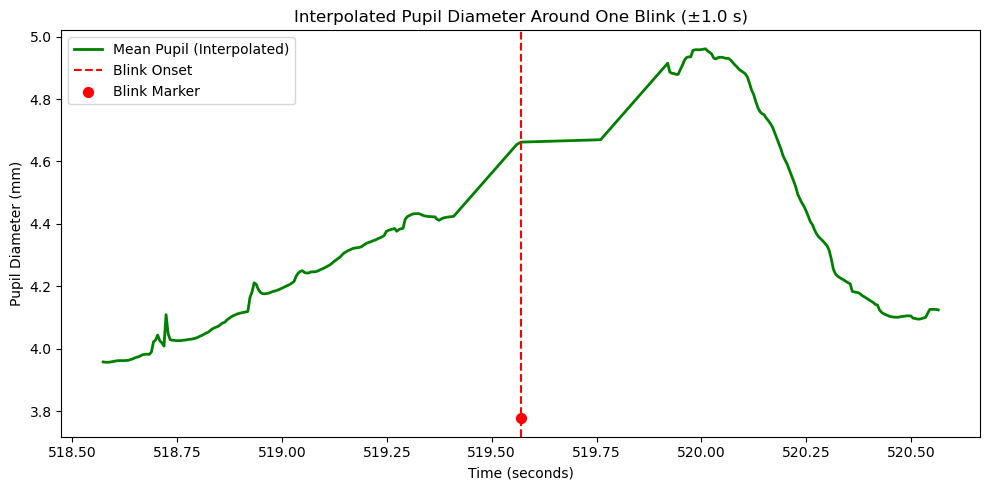

In [ ]:
# Parameters
window_before = 1.0  # seconds before the blink
window_after = 1.0   # seconds after the blink

# Find index of first blink occurrence
first_blink_idx = clean_df.index[clean_df['blink']].min()

# Get the time of this blink
blink_time = clean_df.loc[first_blink_idx, 'time']

# Define time range for the window
start_time = blink_time - window_before
end_time = blink_time + window_after

# Subset data within this window
window_df = clean_df[(clean_df['time'] >= start_time) & (clean_df['time'] <= end_time)]

# Plotting
plt.figure(figsize=(10, 5))

# # For right and left eyes
# plt.plot(window_df['time'], window_df['left_pupil_diameter'], label='Left Pupil (Interpolated)', linewidth=2)
# plt.plot(window_df['time'], window_df['right_pupil_diameter'], label='Right Pupil (Interpolated)', linewidth=2)

# For mean of both eyes
plt.plot(window_df['time'], window_df['mean_pupil_diameter'], color='green', label='Mean Pupil (Interpolated)', linewidth=2)

plt.axvline(blink_time, color='red', linestyle='--', label='Blink Onset')

fixed_y = window_df[['left_pupil_diameter', 'right_pupil_diameter']].min().min() - 0.1
plt.scatter([blink_time], [fixed_y], color='red', s=50, label='Blink Marker')

plt.xlabel('Time (seconds)')
plt.ylabel('Pupil Diameter (mm)')
plt.title(f'Interpolated Pupil Diameter Around One Blink (±{window_before} s)')
plt.legend()
plt.tight_layout()
plt.show()